Copyright (c) Microsoft Corporation. All rights reserved. 

Licensed under the MIT License.

# AutoML with FLAML Library


## 1. Introduction

FLAML is a Python library (https://github.com/microsoft/FLAML) designed to automatically produce accurate machine learning models 
with low computational cost. It is fast and economical. The simple and lightweight design makes it easy to use and extend, such as adding new learners. FLAML can 
- serve as an economical AutoML engine,
- be used as a fast hyperparameter tuning tool, or 
- be embedded in self-tuning software that requires low latency & resource in repetitive
   tuning tasks.

In this notebook, we use one real data example (binary classification) to showcase how to use FLAML library.

FLAML requires `Python>=3.6`. To run this notebook example, please install flaml with the `notebook` option:
```bash
pip install flaml[notebook]
```

In [ ]:
!pip install flaml[notebook];
# from v0.6.6, catboost is made an optional dependency to build conda package.
# to install catboost without installing the notebook option, you can run:
# !pip install flaml[catboost]

## 2. Classification Example
### Load data and preprocess

Download [Airlines dataset](https://www.openml.org/d/1169) from OpenML. The task is to predict whether a given flight will be delayed, given the information of the scheduled departure.

In [ ]:
from flaml.data import load_openml_dataset
X_train, X_test, y_train, y_test = load_openml_dataset(dataset_id=1169, data_dir='./')

### Run FLAML
In the FLAML automl run configuration, users can specify the task type, time budget, error metric, learner list, whether to subsample, resampling strategy type, and so on. All these arguments have default values which will be used if users do not provide them. For example, the default classifiers are `['lgbm', 'xgboost', 'xgb_limitdepth', 'catboost', 'rf', 'extra_tree', 'lrl1']`. 

In [2]:
''' import AutoML class from flaml package '''
from flaml import AutoML
automl = AutoML()

In [3]:
settings = {
    "time_budget": 240,  # total running time in seconds
    "metric": 'accuracy',  # can be: 'r2', 'rmse', 'mae', 'mse', 'accuracy', 'roc_auc', 'roc_auc_ovr',
                           # 'roc_auc_ovo', 'log_loss', 'mape', 'f1', 'ap', 'ndcg', 'micro_f1', 'macro_f1'
    "task": 'classification',  # task type
    "log_file_name": 'airlines_experiment.log',  # flaml log file
    "seed": 7654321,    # random seed
    "n_jobs": 1,
}

In [4]:
'''The main flaml automl API'''
automl.fit(X_train=X_train, y_train=y_train, **settings)

[flaml.automl: 03-23 16:15:35] {2078} INFO - task = classification
[flaml.automl: 03-23 16:15:35] {2080} INFO - Data split method: stratified
[flaml.automl: 03-23 16:15:35] {2084} INFO - Evaluation method: holdout
[flaml.automl: 03-23 16:15:35] {2161} INFO - Minimizing error metric: 1-accuracy
[flaml.automl: 03-23 16:15:35] {2254} INFO - List of ML learners in AutoML Run: ['lgbm', 'rf', 'catboost', 'xgboost', 'extra_tree', 'xgb_limitdepth', 'lrl1']
[flaml.automl: 03-23 16:15:35] {2540} INFO - iteration 0, current learner lgbm
[flaml.automl: 03-23 16:15:35] {2670} INFO - Estimated sufficient time budget=27541s. Estimated necessary time budget=676s.
[flaml.automl: 03-23 16:15:35] {2717} INFO -  at 0.7s,	estimator lgbm's best error=0.3777,	best estimator lgbm's best error=0.3777
[flaml.automl: 03-23 16:15:35] {2540} INFO - iteration 1, current learner lgbm
[flaml.automl: 03-23 16:15:35] {2717} INFO -  at 0.7s,	estimator lgbm's best error=0.3777,	best estimator lgbm's best error=0.3777
[fl

### Best model and metric

In [5]:
'''retrieve best config and best learner'''
print('Best ML leaner:', automl.best_estimator)
print('Best hyperparmeter config:', automl.best_config)
print('Best accuracy on validation data: {0:.4g}'.format(1-automl.best_loss))
print('Training duration of best run: {0:.4g} s'.format(automl.best_config_train_time))

Best ML leaner: lgbm
Best hyperparmeter config: {'n_estimators': 150, 'num_leaves': 176, 'min_child_samples': 62, 'learning_rate': 0.2607939951456863, 'log_max_bin': 8, 'colsample_bytree': 1.0, 'reg_alpha': 0.015973158305354482, 'reg_lambda': 1.1581244082992255, 'FLAML_sample_size': 364083}
Best accuracy on validation data: 0.6718
Training duration of best run: 3.165 s


In [6]:
automl.model.estimator

LGBMClassifier(learning_rate=0.2607939951456863, max_bin=255,
               min_child_samples=62, n_estimators=150, n_jobs=1, num_leaves=176,
               reg_alpha=0.015973158305354482, reg_lambda=1.1581244082992255,
               verbose=-1)

In [7]:
'''pickle and save the automl object'''
import pickle
with open('automl.pkl', 'wb') as f:
    pickle.dump(automl, f, pickle.HIGHEST_PROTOCOL)
'''load pickled automl object'''
with open('automl.pkl', 'rb') as f:
    automl = pickle.load(f)

In [ ]:
'''compute predictions of testing dataset''' 
y_pred = automl.predict(X_test)
print('Predicted labels', y_pred)
print('True labels', y_test)
y_pred_proba = automl.predict_proba(X_test)[:,1]

In [9]:
''' compute different metric values on testing dataset'''
from flaml.ml import sklearn_metric_loss_score
print('accuracy', '=', 1 - sklearn_metric_loss_score('accuracy', y_pred, y_test))
print('roc_auc', '=', 1 - sklearn_metric_loss_score('roc_auc', y_pred_proba, y_test))
print('log_loss', '=', sklearn_metric_loss_score('log_loss', y_pred_proba, y_test))

accuracy = 0.670713258087003
roc_auc = 0.7233411620620108
log_loss = 0.6053791633186667


See Section 4 for an accuracy comparison with default LightGBM and XGBoost.

### Log history

In [10]:
from flaml.data import get_output_from_log
time_history, best_valid_loss_history, valid_loss_history, config_history, metric_history = \
    get_output_from_log(filename=settings['log_file_name'], time_budget=240)
for config in config_history:
    print(config)

{'Current Learner': 'lgbm', 'Current Sample': 10000, 'Current Hyper-parameters': {'n_estimators': 4, 'num_leaves': 4, 'min_child_samples': 20, 'learning_rate': 0.09999999999999995, 'log_max_bin': 8, 'colsample_bytree': 1.0, 'reg_alpha': 0.0009765625, 'reg_lambda': 1.0, 'FLAML_sample_size': 10000}, 'Best Learner': 'lgbm', 'Best Hyper-parameters': {'n_estimators': 4, 'num_leaves': 4, 'min_child_samples': 20, 'learning_rate': 0.09999999999999995, 'log_max_bin': 8, 'colsample_bytree': 1.0, 'reg_alpha': 0.0009765625, 'reg_lambda': 1.0, 'FLAML_sample_size': 10000}}
{'Current Learner': 'lgbm', 'Current Sample': 10000, 'Current Hyper-parameters': {'n_estimators': 26, 'num_leaves': 4, 'min_child_samples': 18, 'learning_rate': 0.22930096764186372, 'log_max_bin': 9, 'colsample_bytree': 0.9086551727646448, 'reg_alpha': 0.0015561782752413472, 'reg_lambda': 0.33127416269768944, 'FLAML_sample_size': 10000}, 'Best Learner': 'lgbm', 'Best Hyper-parameters': {'n_estimators': 26, 'num_leaves': 4, 'min_ch

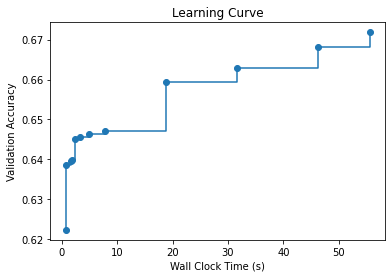

In [11]:
import matplotlib.pyplot as plt
import numpy as np

plt.title('Learning Curve')
plt.xlabel('Wall Clock Time (s)')
plt.ylabel('Validation Accuracy')
plt.scatter(time_history, 1 - np.array(valid_loss_history))
plt.step(time_history, 1 - np.array(best_valid_loss_history), where='post')
plt.show()

## 3. Comparison with alternatives


### Default LightGBM

In [12]:
from lightgbm import LGBMClassifier
lgbm = LGBMClassifier()

In [ ]:
lgbm.fit(X_train, y_train)

In [14]:
y_pred_lgbm = lgbm.predict(X_test)

### Default XGBoost

In [15]:
from xgboost import XGBClassifier
xgb = XGBClassifier()
cat_columns = X_train.select_dtypes(include=['category']).columns
X = X_train.copy()
X[cat_columns] = X[cat_columns].apply(lambda x: x.cat.codes)


In [ ]:
xgb.fit(X, y_train)

In [17]:
X = X_test.copy()
X[cat_columns] = X[cat_columns].apply(lambda x: x.cat.codes)
y_pred_xgb = xgb.predict(X)

In [18]:
print('default xgboost accuracy', '=', 1 - sklearn_metric_loss_score('accuracy', y_pred_xgb, y_test))
print('default lgbm accuracy', '=', 1 - sklearn_metric_loss_score('accuracy', y_pred_lgbm, y_test))
print('flaml (4min) accuracy', '=', 1 - sklearn_metric_loss_score('accuracy', y_pred, y_test))

default xgboost accuracy = 0.6676060098186078
default lgbm accuracy = 0.6602346380315323
flaml (4min) accuracy = 0.670713258087003


## 4. Customized Learner

Some experienced automl users may have a preferred model to tune or may already have a reasonably by-hand-tuned model before launching the automl experiment. They need to select optimal configurations for the customized model mixed with standard built-in learners. 

FLAML can easily incorporate customized/new learners (preferably with sklearn API) provided by users in a real-time manner, as demonstrated below.

### Example of Regularized Greedy Forest

[Regularized Greedy Forest](https://arxiv.org/abs/1109.0887) (RGF) is a machine learning method currently not included in FLAML. The RGF has many tuning parameters, the most critical of which are: `[max_leaf, n_iter, n_tree_search, opt_interval, min_samples_leaf]`. To run a customized/new learner, the user needs to provide the following information:
* an implementation of the customized/new learner
* a list of hyperparameter names and types
* rough ranges of hyperparameters (i.e., upper/lower bounds)
* choose initial value corresponding to low cost for cost-related hyperparameters (e.g., initial value for max_leaf and n_iter should be small)

In this example, the above information for RGF is wrapped in a python class called *MyRegularizedGreedyForest* that exposes the hyperparameters.

In [19]:
''' SKLearnEstimator is the super class for a sklearn learner '''
from flaml.model import SKLearnEstimator
from flaml import tune
from flaml.data import CLASSIFICATION


class MyRegularizedGreedyForest(SKLearnEstimator):
    def __init__(self, task='binary', **config):
        '''Constructor
        
        Args:
            task: A string of the task type, one of
                'binary', 'multi', 'regression'
            config: A dictionary containing the hyperparameter names
                and 'n_jobs' as keys. n_jobs is the number of parallel threads.
        '''

        super().__init__(task, **config)

        '''task=binary or multi for classification task'''
        if task in CLASSIFICATION:
            from rgf.sklearn import RGFClassifier

            self.estimator_class = RGFClassifier
        else:
            from rgf.sklearn import RGFRegressor
            
            self.estimator_class = RGFRegressor

    @classmethod
    def search_space(cls, data_size, task):
        '''[required method] search space

        Returns:
            A dictionary of the search space. 
            Each key is the name of a hyperparameter, and value is a dict with
                its domain (required) and low_cost_init_value, init_value,
                cat_hp_cost (if applicable).
                e.g.,
                {'domain': tune.randint(lower=1, upper=10), 'init_value': 1}.
        '''
        space = {        
            'max_leaf': {'domain': tune.lograndint(lower=4, upper=data_size[0]), 'init_value': 4, 'low_cost_init_value': 4},
            'n_iter': {'domain': tune.lograndint(lower=1, upper=data_size[0]), 'init_value': 1, 'low_cost_init_value': 1},
            'n_tree_search': {'domain': tune.lograndint(lower=1, upper=32768), 'init_value': 1, 'low_cost_init_value': 1},
            'opt_interval': {'domain': tune.lograndint(lower=1, upper=10000), 'init_value': 100},
            'learning_rate': {'domain': tune.loguniform(lower=0.01, upper=20.0)},
            'min_samples_leaf': {'domain': tune.lograndint(lower=1, upper=20), 'init_value': 20},
        }
        return space

    @classmethod
    def size(cls, config):
        '''[optional method] memory size of the estimator in bytes
        
        Args:
            config - the dict of the hyperparameter config

        Returns:
            A float of the memory size required by the estimator to train the
            given config
        '''
        max_leaves = int(round(config['max_leaf']))
        n_estimators = int(round(config['n_iter']))
        return (max_leaves * 3 + (max_leaves - 1) * 4 + 1.0) * n_estimators * 8

    @classmethod
    def cost_relative2lgbm(cls):
        '''[optional method] relative cost compared to lightgbm
        '''
        return 1.0


### Add Customized Learner and Run FLAML AutoML

After adding RGF into the list of learners, we run automl by tuning hyperpameters of RGF as well as the default learners. 

In [20]:
automl = AutoML()
automl.add_learner(learner_name='RGF', learner_class=MyRegularizedGreedyForest)

In [21]:
settings = {
    "time_budget": 10,  # total running time in seconds
    "metric": 'accuracy', 
    "estimator_list": ['RGF', 'lgbm', 'rf', 'xgboost'],  # list of ML learners
    "task": 'classification',  # task type    
    "log_file_name": 'airlines_experiment_custom_learner.log',  # flaml log file 
    "log_training_metric": True,  # whether to log training metric
}

automl.fit(X_train=X_train, y_train=y_train, **settings)

[flaml.automl: 03-23 16:19:50] {2078} INFO - task = classification
[flaml.automl: 03-23 16:19:50] {2080} INFO - Data split method: stratified
[flaml.automl: 03-23 16:19:50] {2084} INFO - Evaluation method: holdout
[flaml.automl: 03-23 16:19:51] {2161} INFO - Minimizing error metric: 1-accuracy
[flaml.automl: 03-23 16:19:51] {2254} INFO - List of ML learners in AutoML Run: ['RGF', 'lgbm', 'rf', 'xgboost']
[flaml.automl: 03-23 16:19:51] {2540} INFO - iteration 0, current learner RGF
/home/qxw5138/miniconda3/envs/ds440flaml/lib/python3.8/site-packages/rgf/utils.py:224: UserWarning: Cannot find FastRGF executable files. FastRGF estimators will be unavailable for usage.
  warnings.warn("Cannot find FastRGF executable files. "
[flaml.automl: 03-23 16:19:51] {2670} INFO - Estimated sufficient time budget=348339s. Estimated necessary time budget=348s.
[flaml.automl: 03-23 16:19:51] {2717} INFO -  at 1.4s,	estimator RGF's best error=0.3840,	best estimator RGF's best error=0.3840
[flaml.automl: 

## 5. Customized Metric

It's also easy to customize the optimization metric. As an example, we demonstrate with a custom metric function which combines training loss and validation loss as the final loss to minimize.

In [22]:
def custom_metric(X_val, y_val, estimator, labels, X_train, y_train,
                  weight_val=None, weight_train=None, config=None,
                  groups_val=None, groups_train=None):
    from sklearn.metrics import log_loss
    import time
    start = time.time()
    y_pred = estimator.predict_proba(X_val)
    pred_time = (time.time() - start) / len(X_val)
    val_loss = log_loss(y_val, y_pred, labels=labels,
                         sample_weight=weight_val)
    y_pred = estimator.predict_proba(X_train)
    train_loss = log_loss(y_train, y_pred, labels=labels,
                          sample_weight=weight_train)
    alpha = 0.5
    return val_loss * (1 + alpha) - alpha * train_loss, {
        "val_loss": val_loss, "train_loss": train_loss, "pred_time": pred_time
    }
    # two elements are returned:
    # the first element is the metric to minimize as a float number,
    # the second element is a dictionary of the metrics to log

We can then pass this custom metric function to automl's `fit` method.

In [23]:
automl = AutoML()
settings = {
    "time_budget": 10,  # total running time in seconds
    "metric": custom_metric,  # pass the custom metric funtion here
    "task": 'classification',  # task type
    "log_file_name": 'airlines_experiment_custom_metric.log',  # flaml log file
}

automl.fit(X_train=X_train, y_train=y_train, **settings)

[flaml.automl: 03-23 16:20:05] {2078} INFO - task = classification
[flaml.automl: 03-23 16:20:05] {2080} INFO - Data split method: stratified
[flaml.automl: 03-23 16:20:05] {2084} INFO - Evaluation method: holdout
[flaml.automl: 03-23 16:20:05] {2161} INFO - Minimizing error metric: customized metric
[flaml.automl: 03-23 16:20:05] {2254} INFO - List of ML learners in AutoML Run: ['lgbm', 'rf', 'catboost', 'xgboost', 'extra_tree', 'xgb_limitdepth', 'lrl1']
[flaml.automl: 03-23 16:20:05] {2540} INFO - iteration 0, current learner lgbm
[flaml.automl: 03-23 16:20:05] {2670} INFO - Estimated sufficient time budget=16433s. Estimated necessary time budget=403s.
[flaml.automl: 03-23 16:20:05] {2717} INFO -  at 0.6s,	estimator lgbm's best error=0.6647,	best estimator lgbm's best error=0.6647
[flaml.automl: 03-23 16:20:05] {2540} INFO - iteration 1, current learner lgbm
[flaml.automl: 03-23 16:20:05] {2717} INFO -  at 0.6s,	estimator lgbm's best error=0.6647,	best estimator lgbm's best error=0.6

## Constraints on the metric(s)
When you are providing a custom metric function, you can also specify constraints on one or more of the metrics reported via the second object, i.e., a metrics_to_log dictionary, returned by the custom metric function.

For example, in the following code, we add a constraint on the `train_loss` metrics and `val_loss` metric reported in `custom_metric` defined above, respectively.

In [24]:
metric_constraints = [("train_loss", "<=", 0.3), ("val_loss", "<=",0.3)]

automl = AutoML()
settings = {
    "time_budget": 30,  # total running time in seconds
    "metric": custom_metric,  # pass the custom metric funtion here
    "task": 'classification',  # task type
    "log_file_name": 'airlines_experiment_custom_metric_constrained.log',  # flaml log file
    "metric_constraints": metric_constraints,
}

automl.fit(X_train=X_train, y_train=y_train, **settings)

[flaml.automl: 03-23 16:20:16] {2078} INFO - task = classification
[flaml.automl: 03-23 16:20:16] {2080} INFO - Data split method: stratified
[flaml.automl: 03-23 16:20:16] {2084} INFO - Evaluation method: holdout
[flaml.automl: 03-23 16:20:16] {2161} INFO - Minimizing error metric: customized metric
[flaml.automl: 03-23 16:20:16] {2254} INFO - List of ML learners in AutoML Run: ['lgbm', 'rf', 'catboost', 'xgboost', 'extra_tree', 'xgb_limitdepth', 'lrl1']
[flaml.automl: 03-23 16:20:16] {2540} INFO - iteration 0, current learner lgbm
[flaml.automl: 03-23 16:20:16] {2670} INFO - Estimated sufficient time budget=15387s. Estimated necessary time budget=378s.
[flaml.automl: 03-23 16:20:16] {2717} INFO -  at 0.6s,	estimator lgbm's best error=0.6647,	best estimator lgbm's best error=0.6647
[flaml.automl: 03-23 16:20:16] {2540} INFO - iteration 1, current learner lgbm
[flaml.automl: 03-23 16:20:16] {2717} INFO -  at 0.7s,	estimator lgbm's best error=0.6647,	best estimator lgbm's best error=0.6